In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from typing import Tuple, Union, List
import time
import cv2
import timm


# Data Loading

In [2]:
from tqdm import tqdm

train_dir = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II"
classes = os.listdir(train_dir)
class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
train_data = []
train_label = []

for i in range(len(classes)):
    dirr = os.path.join(train_dir, classes[i])
    print(f"Processing class: {classes[i]}")
    for names in tqdm(os.listdir(dirr)):
        filedir = os.path.join(dirr, names)
        nparray = np.load(filedir, allow_pickle=True)
        if nparray.shape[0] != 64:
            train_data.append(nparray[0])
        else:
            train_data.append(nparray)
        train_label.append(class_dict[classes[i]])

# Convert lists to numpy arrays for further processing
train_data = np.array(train_data)
train_label = np.array(train_label)

print(f"Data shape: {train_data.shape}")
print(f"Labels shape: {train_label.shape}")


Processing class: axion


100%|██████████| 29896/29896 [04:53<00:00, 101.69it/s]


Processing class: no_sub


100%|██████████| 29449/29449 [05:27<00:00, 89.79it/s]


Processing class: cdm


100%|██████████| 29759/29759 [04:50<00:00, 102.28it/s]


Data shape: (89104, 64, 64)
Labels shape: (89104,)


In [3]:
split = True
if not split:
    test_dir = "/kaggle/input/train-deeplense1-2/Model_III-002/Model_III"
    classes = os.listdir(test_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    test_data = []
    test_label = []

    for i in range(len(classes)):
        dirr = os.path.join(test_dir, classes[i])
        count = 0
        for names in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, names)
            nparray = np.load(filedir, allow_pickle=True)
            if nparray.shape[0] != 64:
                test_data.append(nparray[0])
            else:
                test_data.append(nparray)
            test_label.append(class_dict[classes[i]])
            count += 1

    # Convert lists to numpy arrays for further processing
    test_data = np.array(test_data)
    test_label = np.array(test_label)

    print(f"Data shape: {test_data.shape}")
    print(f"Labels shape: {test_label.shape}")

if split:
    from sklearn.model_selection import train_test_split
    train_data,test_data,train_label,test_label = train_test_split(train_data,train_label,test_size = 0.2)

In [4]:
def preprocess(image):
    imax = np.max(image)
    log = np.square(np.log(imax/image))
    gradient = np.gradient(np.gradient(log,axis =0),axis=1)
    tan = np.tanh(gradient)
    absolute = np.abs(tan)
    return absolute 

In [5]:
class Dataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        #image/=np.max(image)
        tar = self.target[idx]
        pre = preprocess(image)
        return torch.tensor(cv2.resize(image,(224,224)), dtype=torch.float),torch.tensor(pre, dtype=torch.float), torch.tensor(tar, dtype=torch.long)

train_dataset = Dataset(train_data,train_label)
test_dataset = Dataset(test_data,test_label)

from torch.utils.data import DataLoader
train_looader = DataLoader(train_dataset,batch_size = 64)
test_looader = DataLoader(test_dataset,batch_size = 64)

# Resnet Gradcam 

In [6]:
class GradCAM(nn.Module):
    def __init__(self, n_channel):
        super(GradCAM, self).__init__()
        self.model = timm.create_model("resnet18", pretrained=True)
        self.model.conv1 = nn.Conv2d(n_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        layers = [
            self.model.conv1,
            self.model.bn1,
            self.model.act1,
            self.model.maxpool,
            self.model.layer1,
            self.model.layer2,
            self.model.layer3,
            self.model.layer4
        ]
        self.modeltill_lastconv = nn.Sequential(*layers)
        self.global_pool = self.model.global_pool
        self.fc = nn.Linear(in_features=512, out_features=3, bias=True)

        self.gradient = None

    def activation_hook(self, grad):
        self.gradient = grad

    def forward(self, x):
        x = self.modeltill_lastconv(x)

        h = x.register_hook(self.activation_hook)

        x = self.global_pool(x)
        x = self.fc(x)
        return x

    def get_activation_gradient(self):
        return self.gradient

    def get_activation_map(self, x):
        return self.modeltill_lastconv(x)



In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_final_model(model, total_training_loader, total_test_loader, n_epochs, optimizer, criterion, device):
    """
    Trains a PyTorch model.

    Args:
    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:
    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set
    """

    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    for it in range(n_epochs):
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        model.train()

        for images, dis, targets in tqdm(total_training_loader):
            images, dis, targets = images.to(device), dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch, 1, 224, 224)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels, preds, average='micro'))

        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)
        mat = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=mat)
        disp.plot()
        plt.show()

        test_loss = []
        test_f1 = []

        model.eval()
        y_true = []
        y_pred = []

        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))

        torch.save(model.state_dict(), 'model.pth')

        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f}')

    return mean_loss_train, mean_f1_train


# Training the model 

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

100%|██████████| 1114/1114 [02:16<00:00,  8.14it/s]


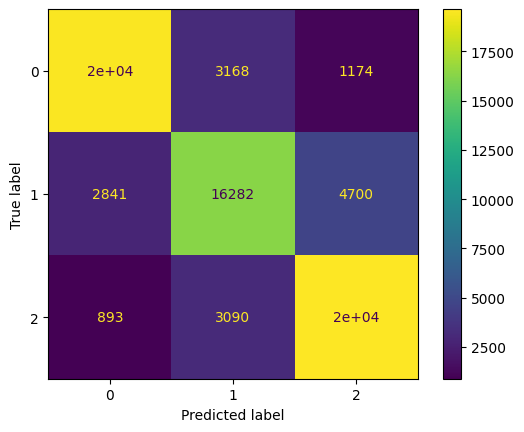

Epoch 0/10, Train Loss: 0.5174, Train F1: 0.7774


100%|██████████| 1114/1114 [02:15<00:00,  8.22it/s]


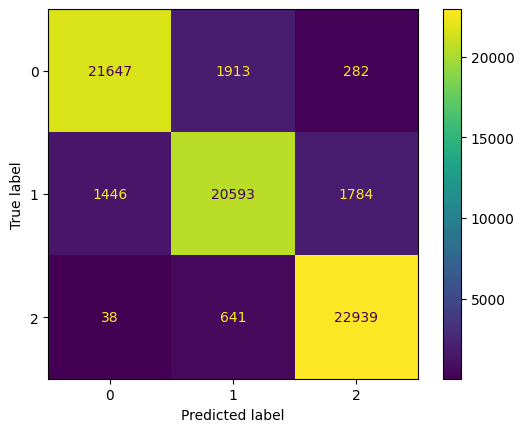

Epoch 1/10, Train Loss: 0.2218, Train F1: 0.9144


100%|██████████| 1114/1114 [02:17<00:00,  8.12it/s]


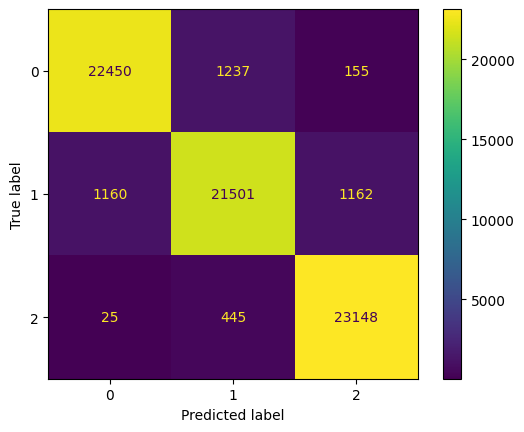

Epoch 2/10, Train Loss: 0.1591, Train F1: 0.9413


100%|██████████| 1114/1114 [02:16<00:00,  8.17it/s]


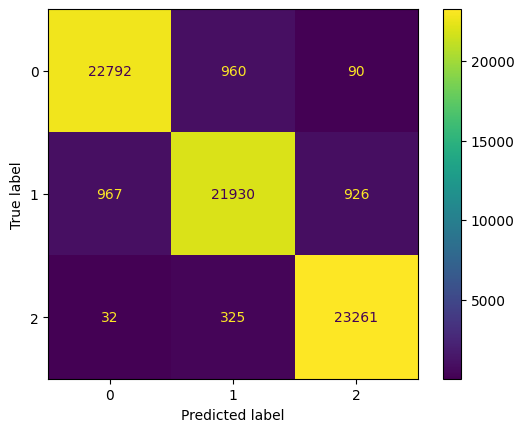

Epoch 3/10, Train Loss: 0.1267, Train F1: 0.9537


100%|██████████| 1114/1114 [02:15<00:00,  8.24it/s]


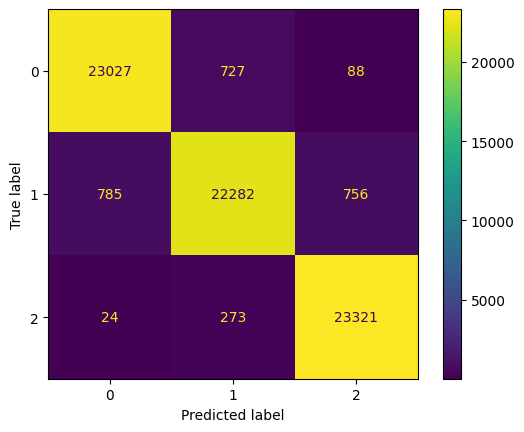

Epoch 4/10, Train Loss: 0.1047, Train F1: 0.9628


100%|██████████| 1114/1114 [02:15<00:00,  8.20it/s]


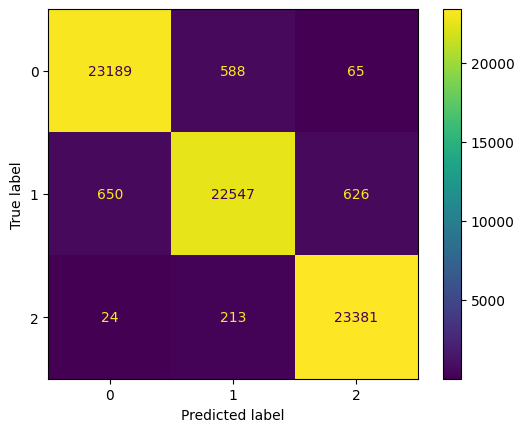

Epoch 5/10, Train Loss: 0.0885, Train F1: 0.9696


100%|██████████| 1114/1114 [02:17<00:00,  8.12it/s]


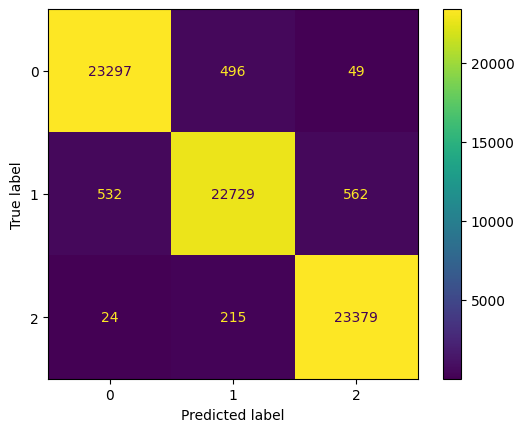

Epoch 6/10, Train Loss: 0.0769, Train F1: 0.9737


100%|██████████| 1114/1114 [02:16<00:00,  8.15it/s]


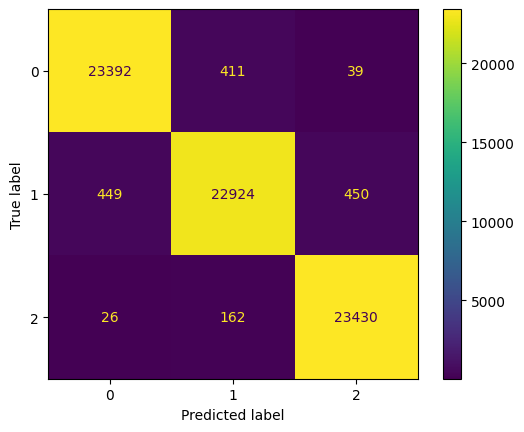

Epoch 7/10, Train Loss: 0.0647, Train F1: 0.9784


100%|██████████| 1114/1114 [02:18<00:00,  8.05it/s]


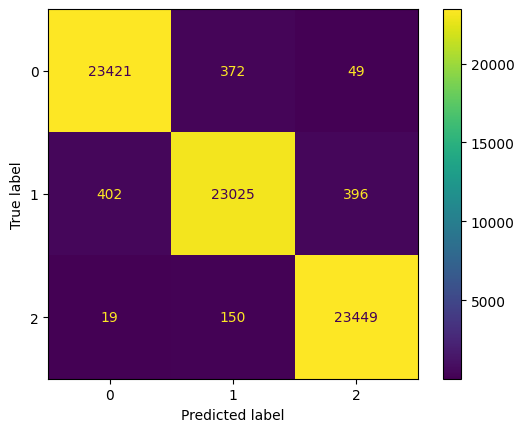

Epoch 8/10, Train Loss: 0.0573, Train F1: 0.9805


100%|██████████| 1114/1114 [02:18<00:00,  8.04it/s]


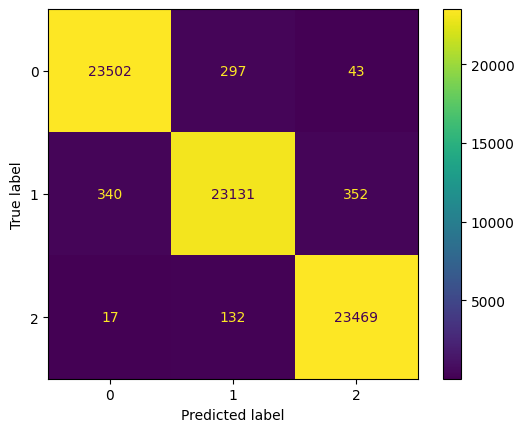

Epoch 9/10, Train Loss: 0.0496, Train F1: 0.9834


In [8]:
model = GradCAM(n_channel=1)
model = model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

mean_loss_train_model,mean_f1_train_model = train_final_model(model,train_looader,test_looader,n_epochs=10,optimizer=optimizer,criterion=criterion,device="cuda")

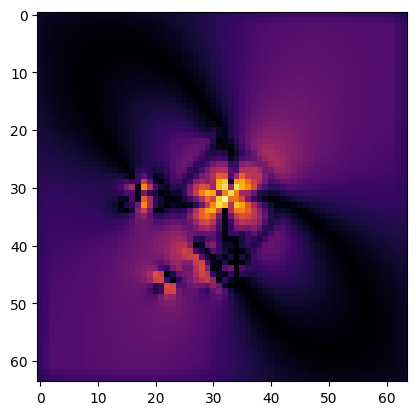

In [9]:
image = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/cdm/cdm_sim_100048449308879421074618370700226627653.npy",allow_pickle = True)
image_resized = cv2.resize(image, (224,224))
plt.imshow(preprocess(image),cmap = "inferno")
plt.show()


In [10]:
def visualize_gradcam(model, image):
    # Ensure the image is in the correct shape
    batch = 1
    image = image.view(batch, 1, 224, 224)
    model.eval()
    
    # Forward pass
    pred = model(image)
    index = pred.argmax(dim=1).item()
    print("The max probability is of class", index)
    
    # Backward pass to get gradients
    pred[:, index].backward()
    
    # Get the gradient of the output with respect to the parameters of the model
    gradients = model.get_activation_gradient()
    
    # Pool the gradients across the channels
    print(gradients.shape)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Get the activations of the last convolutional layer
    activations = model.get_activation_map(image).detach()
    
    # Weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    
    # Normalize the heatmap
    heatmap /= torch.max(heatmap)
    print(heatmap)
    
    # Convert heatmap to uint8 format
    heatmap = np.uint8(255 * heatmap)
    
    # Resize heatmap to match original image size
    heatmap = cv2.resize(np.array(heatmap), (224, 224))
    
    # Convert image tensor to numpy array and reshape for visualization
    image_np = image.cpu().numpy().squeeze()
    
    # Plot
    fig, ax = plt.subplots()

    ax.imshow(preprocess(image_np), cmap='gray', alpha=1.0)

    heatmap = ax.imshow(heatmap, cmap='jet', alpha=0.5)
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Grad-CAM Intensity')
    plt.axis('off')
    plt.show()


In [11]:
def plot(path):
    image = np.load(path,allow_pickle = True)
    if image.shape[0]!=64:
        image = image[0]
    plt.imshow(image)
    plt.title("image")
    plt.show()
    plt.imshow(preprocess(image))
    plt.title("distortion")
    plt.show()
    image_resized = cv2.resize(image,(224,224))
    visualize_gradcam(model.to("cpu"),torch.tensor(image_resized,dtype = torch.float32))

In [12]:
axion = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/axion/axion_sim_100002416878418427304850085227078375469.npy"
cdm = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/cdm/cdm_sim_100055535261996859115524197346297773871.npy"
nosub = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/no_sub/no_sub_sim_100111923934755689875491780645183892888.npy"


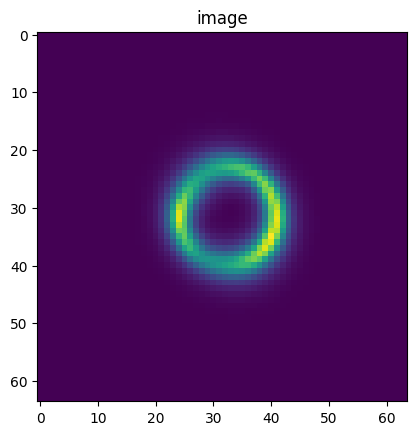

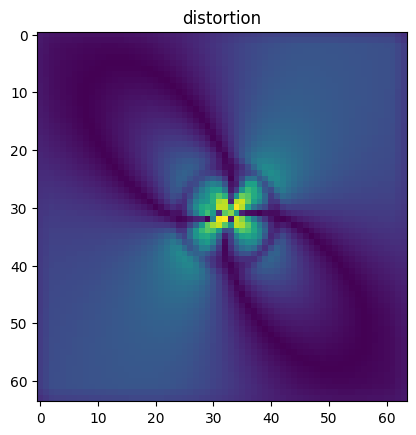

The max probability is of class 0
torch.Size([1, 512, 7, 7])
tensor([[7.7423e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.6728e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9738e-03, 1.3382e-02, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.9746e-01, 4.7175e-01, 2.8806e-01, 3.7928e-02,
         1.8693e-03],
        [0.0000e+00, 1.5195e-02, 5.9268e-01, 8.8737e-01, 8.8805e-01, 2.5101e-01,
         1.0691e-02],
        [1.9379e-03, 1.8390e-02, 5.5892e-01, 1.0000e+00, 9.4653e-01, 3.6466e-01,
         1.4533e-02],
        [0.0000e+00, 5.7658e-03, 2.1128e-01, 5.7344e-01, 5.0602e-01, 1.0557e-01,
         7.2999e-03],
        [7.3911e-04, 1.2866e-03, 5.9192e-03, 2.4876e-02, 1.6743e-02, 3.7894e-03,
         7.9731e-04]])


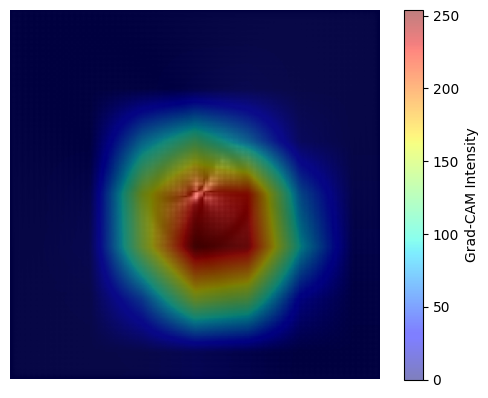

In [13]:
plot(axion)

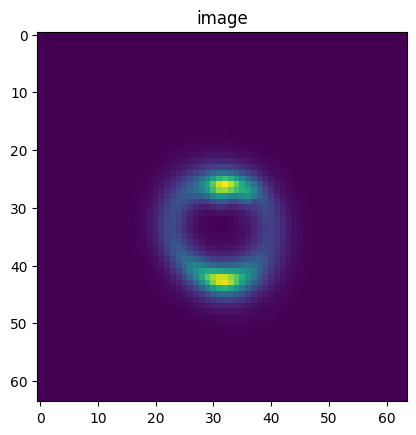

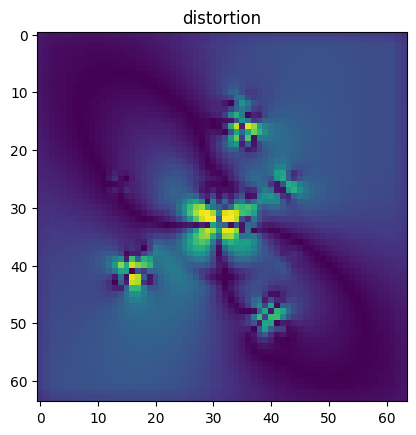

The max probability is of class 1
torch.Size([1, 512, 7, 7])
tensor([[0.0000e+00, 7.1962e-03, 1.4249e-02, 1.2574e-02, 2.4270e-02, 2.0224e-02,
         4.0786e-04],
        [2.2398e-04, 1.8471e-02, 8.4117e-02, 3.0854e-01, 3.1453e-01, 2.4231e-01,
         6.1222e-02],
        [1.0629e-02, 9.6901e-02, 3.1925e-01, 6.0910e-01, 8.0031e-01, 5.0304e-01,
         1.7719e-01],
        [1.0534e-02, 1.1976e-01, 4.4969e-01, 7.9135e-01, 1.0000e+00, 7.4658e-01,
         3.2415e-01],
        [1.3548e-02, 6.1664e-02, 3.1703e-01, 6.3214e-01, 8.6139e-01, 5.8655e-01,
         2.3487e-01],
        [2.3179e-03, 4.1303e-02, 2.4266e-01, 5.7712e-01, 7.9428e-01, 3.4003e-01,
         9.5150e-02],
        [0.0000e+00, 0.0000e+00, 3.0829e-02, 1.6662e-01, 1.8058e-01, 6.6385e-02,
         8.5194e-03]])


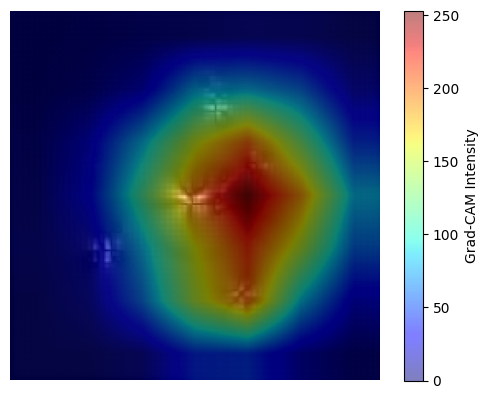

In [14]:
plot(cdm)

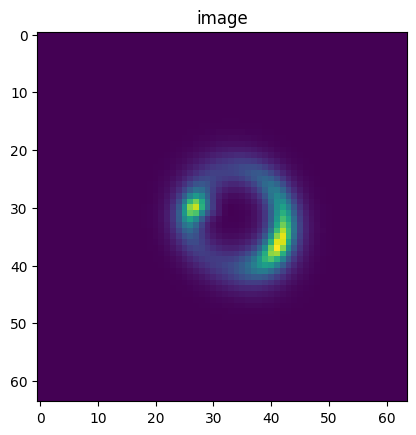

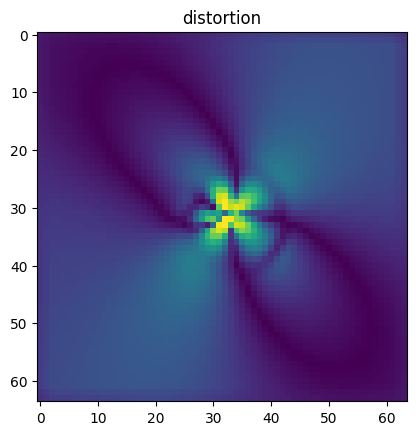

The max probability is of class 2
torch.Size([1, 512, 7, 7])
tensor([[9.0346e-04, 2.7360e-02, 6.1829e-03, 2.8706e-03, 4.4460e-03, 1.3614e-02,
         5.1347e-03],
        [2.2251e-02, 4.3722e-02, 1.1463e-01, 1.0069e-01, 1.0003e-01, 1.5507e-03,
         0.0000e+00],
        [3.3252e-02, 2.0640e-01, 7.1455e-01, 6.5777e-01, 6.5181e-01, 2.7196e-01,
         0.0000e+00],
        [2.0817e-02, 2.7407e-01, 8.3509e-01, 1.0000e+00, 6.9489e-01, 2.7515e-01,
         1.3077e-02],
        [2.0261e-02, 2.6063e-01, 6.3148e-01, 8.6657e-01, 6.6397e-01, 1.0261e-01,
         0.0000e+00],
        [3.4419e-02, 1.9925e-01, 4.9511e-01, 3.9590e-01, 2.0395e-01, 0.0000e+00,
         0.0000e+00],
        [2.4612e-02, 2.6608e-02, 8.1405e-02, 5.2511e-02, 3.8629e-02, 2.1563e-02,
         3.6403e-03]])


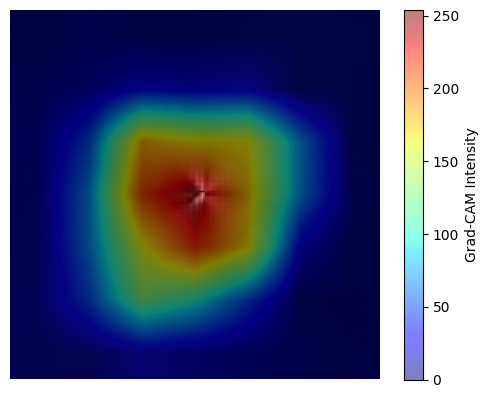

In [15]:
plot(nosub)

# Grad-CAM Visualization Results

## Introduction

Grad-CAM (Gradient-weighted Class Activation Mapping) visualization helps us understand the regions where the model is focusing more. This is crucial for our ultimate purpose of studying dark matter morphology. The dark matter is responsible for the formation of lensing images, and the differences between these lensing images are due to varying substructures.

## Visualization Results

Below are some results from the Grad-CAM visualization:

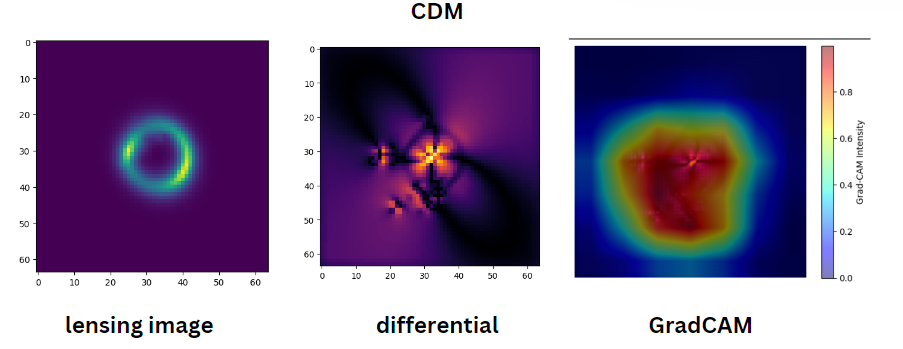
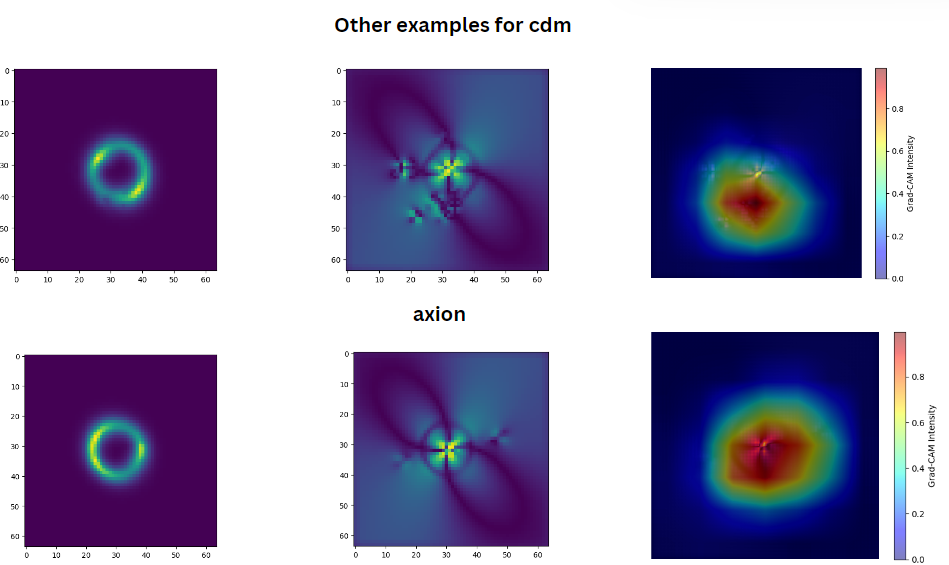
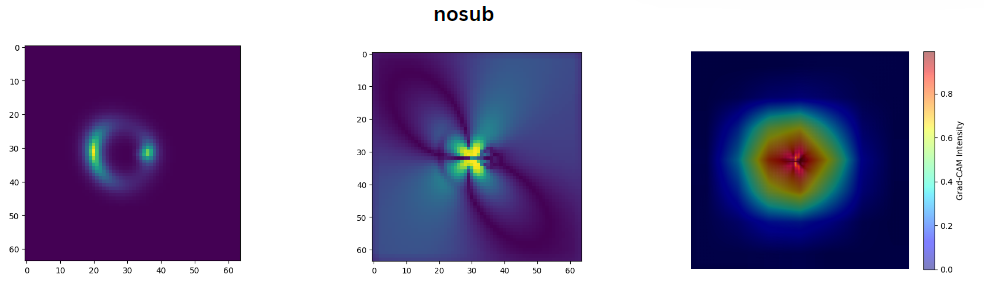

## Insights

The Grad-CAM visualization highlights the regions where our model focuses, revealing the influence of dark matter in the formation of lensing images. By examining these visualizations, we can better understand the substructures of dark matter causing the differences in the lensing images.

### Key Points

- We can see for the CDM it is focusing on the distorted area even though the model is not fed with the distortion of the differential.
- GradCAM (Gradient-weighted Class Activation Mapping) relies heavily on the model's weights and gradients, making it sensitive to various factors that can affect reproducibility as it also depends upon Model Weights Initialization which is random for it we have to fix the seed.
- Differences in lensing images are due to varying substructures of dark matter.